# Threshold Event detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wavely.signal.features import features
from wavely.signal.preprocessing import preprocessing
from wavely.signal.processing.event_detection import event_detection
from wavely.signal.units import helpers, converters
from scipy import signal as scip_signal


## Signal Creation

In [2]:
# Data for Threshold Event Detector
f1 = 200; f2 = 7000; f3 = 4500
rate = 16000
time = np.arange(0, 0.8*rate) / rate

# Multiples chirp signals used to construct the signal for spectral
# centroid variation. The ThresholdEventDetector test is done with
# spectral centroid feature.
signal_chirp1 = scip_signal.chirp(time, 0, 1, f2, method='linear') * 0.5
signal_chirp2 = scip_signal.chirp(time, f1, 1, f2, method='linear') * 0.5
signal_chirp3 = scip_signal.chirp(time, f3, 1, f1, method='linear') * 0.5
signal_chirp4 = scip_signal.chirp(time, f1, 1, f2, method='linear') * 0.5
signal_chirp5 = scip_signal.chirp(time, f2, 1, 0, method='linear') * 0.5

block_duration = 0.05
signal = np.concatenate([signal_chirp1, signal_chirp2, signal_chirp3, signal_chirp4, signal_chirp5])
time = np.arange(0, (len(signal)-1)/rate, 1/rate)


The signal is a succession of chirp signal. The aim of this signal is to choose wisely the `spectralcentroid` of the input signal. 

### Split signal and compute features

In [3]:
window_length = int(block_duration * rate)
blocks = helpers.split_signal(signal, rate, block_duration)
num_frames = blocks.shape[0]

n_fft = int(block_duration * rate)
features_processor = features.FeaturesComputer(
    block_size=window_length, rate=rate, n_fft=n_fft, features=["rms", "audiblelevel", "ultrasoundlevel", "spectralcentroid"]
)

normalized_blocks = preprocessing.calibrate_audio_signal(
    blocks=blocks, preamp_gain=0, microphone="Digital"
)
blocks_features = features_processor.compute(normalized_blocks, flatten=True)
timestamps = pd.to_timedelta([i * block_duration for i in range(num_frames)], unit="s")
display_timestamp = [i * block_duration for i in range(num_frames)]

computed_features = pd.DataFrame(blocks_features, index=timestamps)
plot_features = computed_features["spectralcentroid"]

threshold = 4500
hysteresis = 1000

### Display spectralcentroid of the signal

Text(0.5, 1.0, 'Spectralcentroid of input signal')

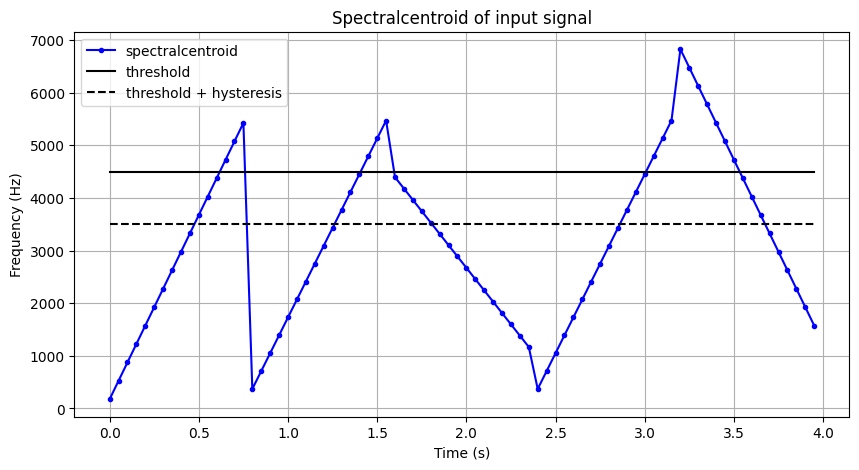

In [4]:
plt.figure(5, figsize=(10,5))
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold + hysteresis')
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectralcentroid of input signal")

# Event detection algorithm

These are the particularity of the event detection algorithm: 
* Every new point, a buffer of feature is tested. The buffer is constructed sequentially until `max_length` points are available, then the older data is replace with the new one. 
* An event is saved either when it ends or when the whole test buffer is above(or below) the threshold level. 
* When an event is saved, there is no more new event until the end of the saved one in the buffer. Then, a processus of synchronisation is done. Everytime a new point arrives, it is store and no detection is done until the beginning of the buffer is synchronized with the end of the last saved.

## Events smaller than `min_length`

### Above: min_value = 4500 Hz - hysteresis = 1000 Hz - min lenght event = 0.6 sec

In [5]:
min_length = 0.6
max_length = 2
min_inter_event_time = 0.0

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=True, 
    min_level=threshold, 
    hysteresis=hysteresis, 
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: Threshold above 4.5kHz')

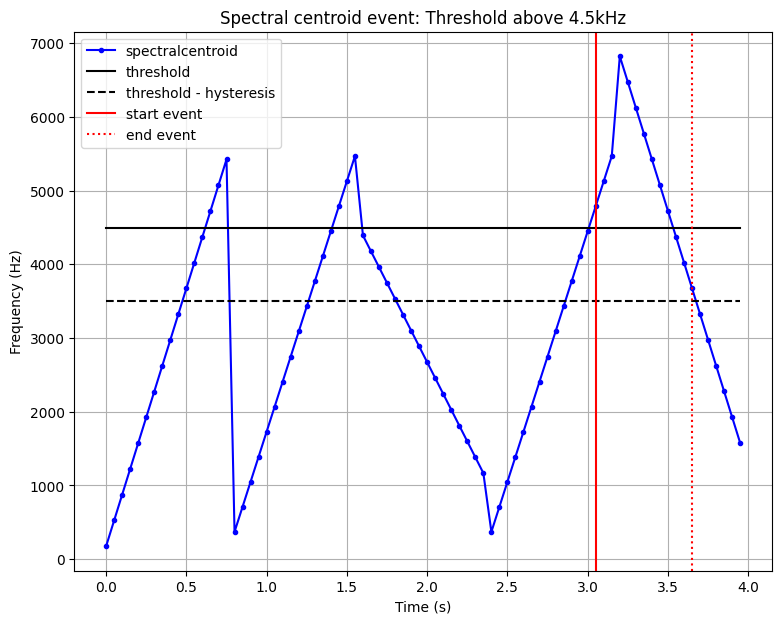

In [6]:
plt.figure(6, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold - hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: Threshold above 4.5kHz")

The spectralcentroid of input data cross the `threshold` level 3 times and the `min_length` parameter is set to 0.6 secondes. 

The two first events are too small to be consider, only the last event is store as expected. The begining of the event correspond to the solid red line and the end is the dash red one.

The solid red line (begining of the event) is slighly after the threshold crossing because only the event above the threshold is saved. 

### Above: min_value = 4500 Hz - hysteresis = 1000 Hz - min lenght event = 0.1 sec - max length event = 2 sec

In [7]:
min_length = 0.1
max_length = 2
min_inter_event_time = 0.0

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=True, 
    min_level=threshold, 
    hysteresis=hysteresis,
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: Threshold above 4.5kHz')

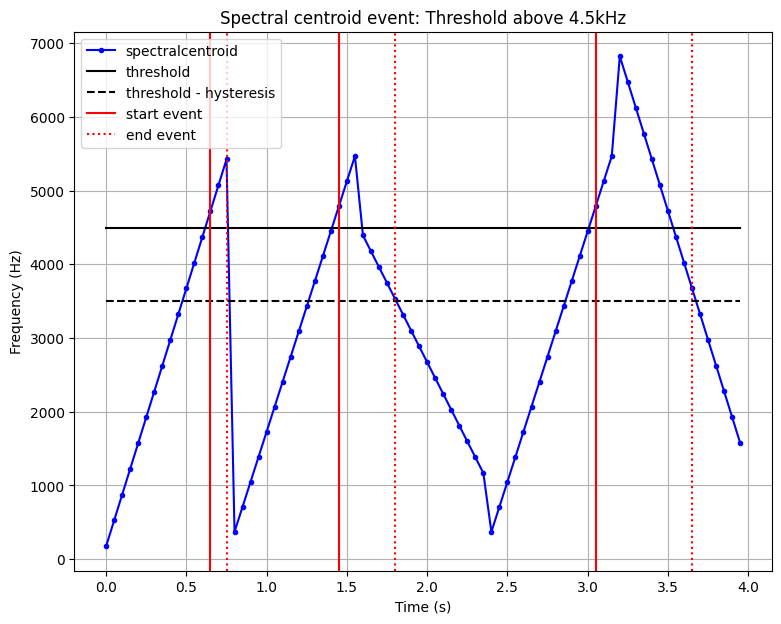

In [8]:
plt.figure(7, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold - hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: Threshold above 4.5kHz")

In this example, the `min_length` value is set to 0.1 sec. The two first events (+ the last one) are now detected and store since they are longer than the minimum length.

## Select a `lowpass_window_length`

In [9]:
min_length = 0.6
max_length = 2
min_inter_event_time = 1.0
lowpass_window_length = 0.1

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=True, 
    min_level=threshold, 
    hysteresis=hysteresis,
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time,
    lowpass_window_length=lowpass_window_length)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: Threshold above 4.5kHz')

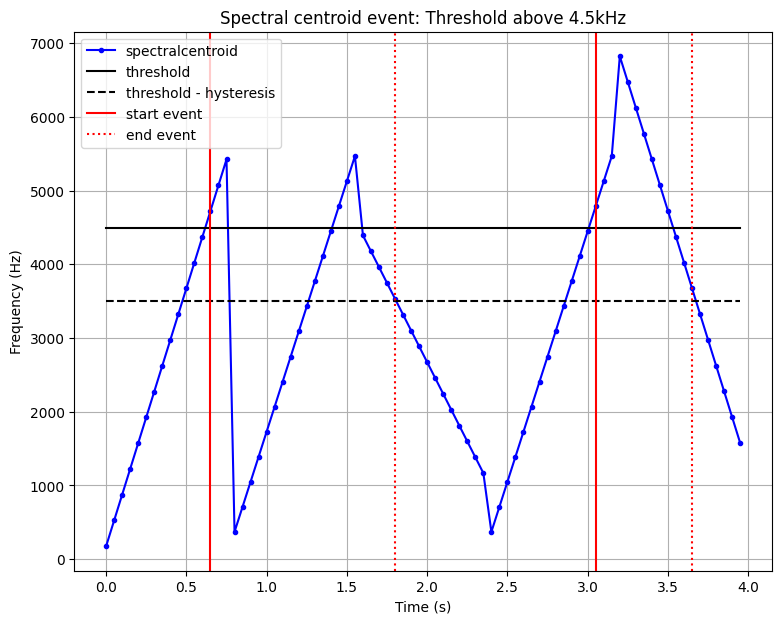

In [10]:
plt.figure(7, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold - hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: Threshold above 4.5kHz")

In this example, we see the two first events are too short to be considered as unique event but still can be merged together. The save of the two events as one is done because they met the requirements following: 
* Event respect : `lowpass_window_length` < event time < `min_length`
* Time between both events < `min_inter_event_time`
* Merge of both event leads to a unique event longer than `min_length`

## Merged events according to `min_inter_event_time`

In [12]:
min_length = 0.1
max_length = 3.5
min_inter_event_time = 1.5

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=True, 
    min_level=threshold, 
    hysteresis=hysteresis, 
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid: merged events with min_inter_event_time parameter')

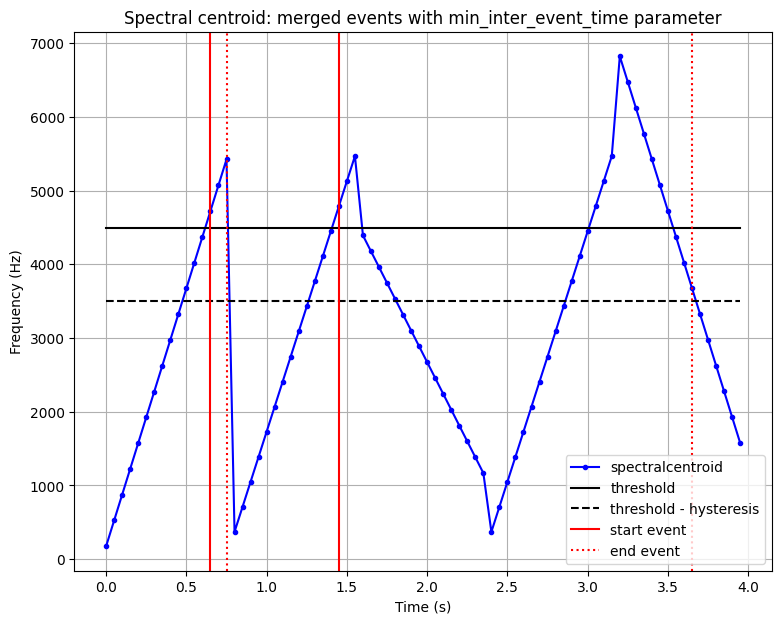

In [13]:
plt.figure(7, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold - hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid: merged events with min_inter_event_time parameter")

For this test, the `min_length` parameter is set to 0.1 and the `min_inter_event_time` parameter to 1.5 sec. 

The algorithm is build to detect the first event as soon as possible (when it is over). The synchronization happends after the first event detection (at 0.5 sec). The second and the third event are in this buffer and they are separated by less than `min_inter_event_time`. They are merged to be one unique event.

## Events longer than `max_length`

### min_value = 4500 Hz - hysteresis = 1000 Hz 
### min length event = 0.1 sec - max lenght event = 0.4 sec

In [14]:
min_length = 0.1
max_length = 0.4 # Max length should be a multiple of block_duration
min_inter_event_time = 0.0

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=True, 
    min_level=threshold, 
    hysteresis=hysteresis,
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time)
        
events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: test max_lenght parameter')

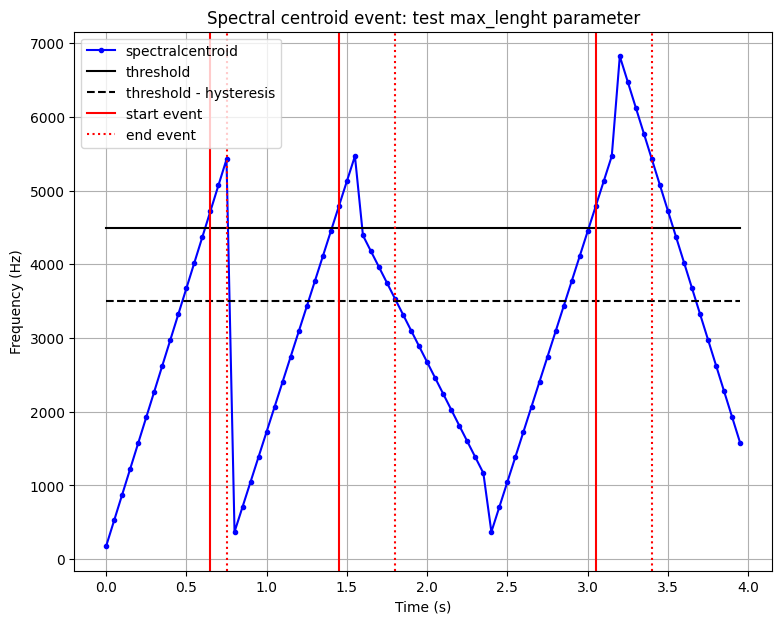

In [15]:
plt.figure(8, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold-hysteresis, '--k', label='threshold - hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: test max_lenght parameter")

The `max_length` variable is set to 0.4 sec. The two first events last more than `min_length` and less than `max_length` so they are saved. For the last event detected (3.05, 3.65), we see it last more than 0.4 sec. The recording is stop at 0.4 sec and not when the `spectralcentroid` curve is crossing the `threshold - hysteresis` curve. 

## Event below threshold (with hysteresis)

### min_value = 4500 Hz - hysteresis = 1000 Hz 
### min lenght event = 0.8 sec - max length event = 2.0

In [16]:
min_length = 0.8
max_length = 2.0
min_inter_event_time = 1.0

threshold = 4000
hysteresis = 1000

threshold_detector = event_detection.ThresholdEventDetector(
    block_duration=block_duration, 
    feature='spectralcentroid', 
    detection_above_threshold=False, 
    min_level=threshold, 
    hysteresis=hysteresis, 
    max_length=max_length, 
    min_length=min_length,
    min_inter_event_time=min_inter_event_time)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: below threshold and merge event')

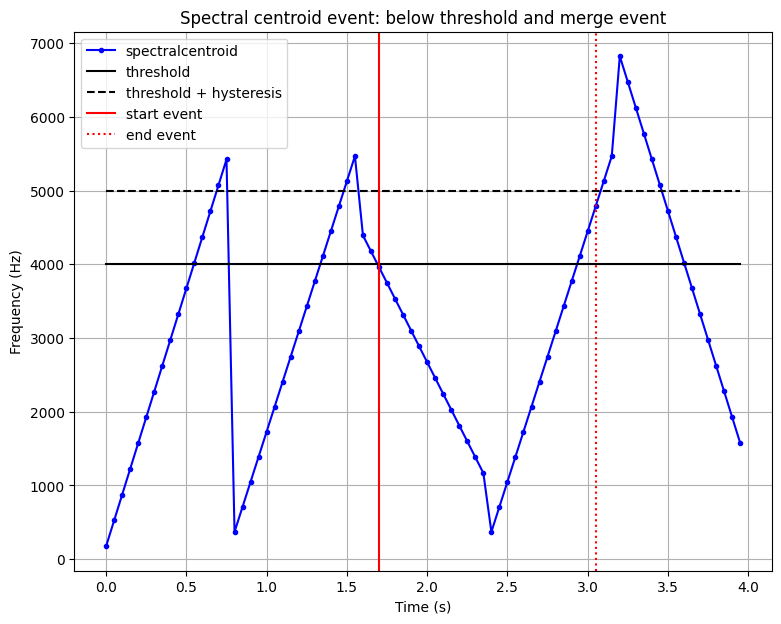

In [17]:
plt.figure(9, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold + hysteresis, '--k', label='threshold + hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: below threshold and merge event")

In this case, the event detection save an event when the value is below the `threshold` and stop the event when the value is above the `threshold + hysteresis` level.

Only the event which starts at 1.7 sec is saved because it last more than `min_length`. The other events are not considered because they are too short to be saved.

## Parameter `max_length`

### Below: min_value = 4500 Hz - hysteresis = 1000 Hz - min lenght event = 0.1 sec - max length = 1.0 - min_inter_event_time = 0.5

In [18]:
min_length = 0.1
max_length = 1.0
min_inter_event_time = 0.5

threshold = 4000
hysteresis = 1000

threshold_detector = event_detection.ThresholdEventDetector(block_duration=block_duration, feature='spectralcentroid', 
                                                        detection_above_threshold=False, min_level=threshold, 
                                                        hysteresis=hysteresis, max_length=max_length, min_length=min_length,
                                                        min_inter_event_time=min_inter_event_time)

events = []
for index, feature in computed_features.iterrows():
    feature = dict(feature)
    feature["time"] = index
    threshold_detector.push(feature)
    event = threshold_detector.pop_event()
    if event is not None:
        events.append(event)
last_events = threshold_detector.flush()

events = events + last_events
valid_events = [(event[0].total_seconds(), event[1].total_seconds()) for event in events]

Text(0.5, 1.0, 'Spectral centroid event: below threshold and max_length parameter')

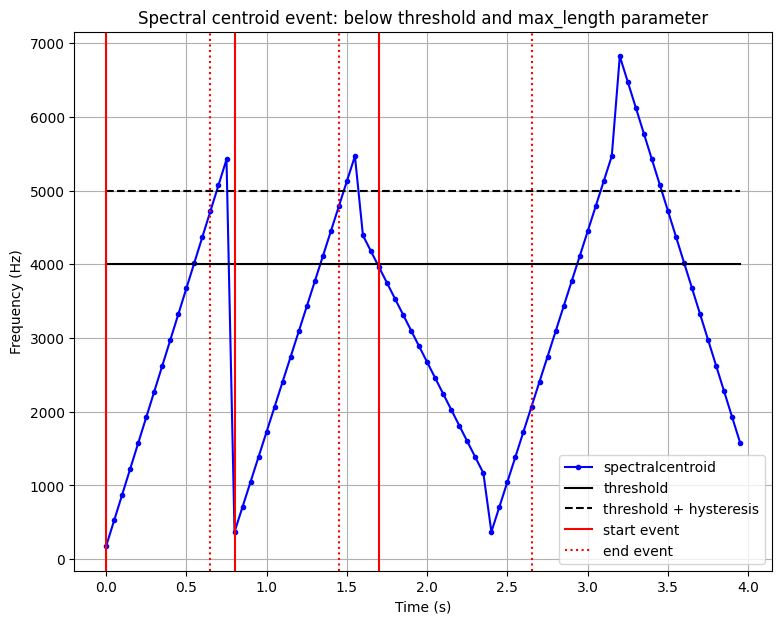

In [19]:
plt.figure(9, figsize=[9,7])
plt.plot(display_timestamp,computed_features["spectralcentroid"],'b.-' , label= 'spectralcentroid')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold, 'k', label='threshold')
plt.plot(display_timestamp, np.ones(len(display_timestamp))*threshold + hysteresis, '--k', label='threshold + hysteresis')
is_first_event = True
for start, end in valid_events:
    if is_first_event:
        plt.axvline(start, color="red", linestyle="solid", label='start event')
        plt.axvline(end, color="red", linestyle="dotted", label='end event')
        is_first_event = False
    else:
        plt.axvline(start, color="red", linestyle="solid")
        plt.axvline(end, color="red", linestyle="dotted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral centroid event: below threshold and max_length parameter")

The `min_length` parameter is set to 0.1 sec and the `min_inter_event_time` to 0.5 sec. Knowing those parameters, the event detection saved the first and the second events as unique since they meet all the requirements. However, the third event last longer than `max_length`. The recording event is cut at `max_length` .